In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.feather_format import read_feather
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.distribute.coordinator.values import PerWorkerDatasetFromDatasetFunction
from tensorflow.python.ops.gen_math_ops import mod, real

In [2]:
### Load Data
company = "TSLA"

start = dt.datetime(2012,1,1)
end = dt.datetime(2020,1,1)

# Getting the data
data = web.DataReader(company, 'yahoo', start, end) # Gives entire spreadsheet of data

In [3]:
### Prepare data
# Scaling it all into one range
scaler = MinMaxScaler(feature_range = (0,1))
# Getting the values of the data from the closer column of the test_data spreadsheet
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1)) # Spreadsheet of data between 0 and 1

# Comparing it with the day 60 days into the future, how data found
prediction_days = 60

x_train = []
y_train = []

# Putting the data into the empty lists, 60 values that we know, model learn what next value going to be
for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0]) # First 60 days
    y_train.append(scaled_data[x, 0]) # Everything other than the 60 days

In [4]:
### Converting to numpy arrays
# Creates a 1D array
x_train, y_train = np.array(x_train), np.array(y_train)
# Reshape works by np.reshape(array you want to reshape, (rows, columns))
# Can do reshape(array changed, length of array) to make one big one together [[1,2,3], [4,5,6]] to [1, 4, 2, 5, 3, 6]
# The extra 1 after shape[1] makes it be a 3D array
# .shape gives the rows and columns of an array
# For [[1,2,3], [4,5,6]] it would be (2,3)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train is a 3D array
# y_train is a 1D array

In [5]:
### Build the model and training

# 3 different models, sequential, functional and model subclassing
# Sequential is the basic one, no multiple inputs, step-by-step
model = Sequential()

# .add command is adding layers to the model

# Try out different numbers, more units more layers = longer training
# Units is dimensionality of output space
# Return_sequences returns the last outside
# Input_shape is how the data looks when it goes in
# x_train.shape[1] gives me the columns of the array
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))

# Dropout fixes overfitting of data, getting rid of stuff so doesn't get too close to original and good adding new data
# When you think abt it, if use all the values from before and only add a couple new ones won't change much on the thing
# But if mess around and throw some stuff in there to fudge the values, more accepting to new ones
# Does it every 0.2 ---> Randomly throws in zeroes into the stuff
model.add(Dropout(0.2))

# Doing it multiple times increases accuracy, deep learning technique
# 'deeper model'
model.add(LSTM(units = 50, return_sequences = True))

model.add(Dropout(0.2))

model.add(LSTM(units = 50))

model.add(Dropout(0.2))

# Don't entirely get what dense does, but supposed to help with below
# Prediction of the next closing value
model.add(Dense(units = 1))

# Different optimizers do different things
# adam is a, quote, stochastic gradient descent method based on adpative esimation of first and second order moments
# SGD, another one I tested, is a gradient descent with momentum (it sucks)
# loss is to compute quantity model should seek to minimize during training
# mean_squared_error computes mean of sequares of errors between labels and prediction
model.compile(optimizer = 'adam', loss = 'mean_absolute_error')

# epochs are phases of training, how many times go through the training set
# batch_size is a number of samples processed before the model is updated
model.fit(x_train, y_train, epochs = 25, batch_size = 32)

Epoch 1/25
61/61 [==============================] - 11s 75ms/step - loss: 0.0938
Epoch 2/25
61/61 [==============================] - 4s 71ms/step - loss: 0.0514
Epoch 3/25
61/61 [==============================] - 4s 71ms/step - loss: 0.0484
Epoch 4/25
61/61 [==============================] - 4s 66ms/step - loss: 0.0472
Epoch 5/25
61/61 [==============================] - 4s 69ms/step - loss: 0.0450
Epoch 6/25
61/61 [==============================] - 5s 78ms/step - loss: 0.0443
Epoch 7/25
61/61 [==============================] - 5s 84ms/step - loss: 0.0448
Epoch 8/25
61/61 [==============================] - 5s 79ms/step - loss: 0.0424
Epoch 9/25
61/61 [==============================] - 5s 79ms/step - loss: 0.0431
Epoch 10/25
61/61 [==============================] - 5s 77ms/step - loss: 0.0411
Epoch 11/25
61/61 [==============================] - 5s 78ms/step - loss: 0.0385
Epoch 12/25
61/61 [==============================] - 4s 73ms/step - loss: 0.0392
Epoch 13/25
61/61 [=================

In [6]:
''' Test the model accuracy on existing data '''

### Load test data

test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

# Getting the data
test_data = web.DataReader(company, 'yahoo', test_start, test_end)

# Getting the values of the data from the closer column of the test_data spreadsheet
actual_prices = test_data['Close'].values

# Needed to make the graph understandable
x_axis_actual_prices = []
for i in range(len(actual_prices)):
    x_axis_actual_prices.append(i/260*365)

# Concatenating across an axis
total_dataset = pd.concat((data['Close'], test_data['Close']))

In [7]:
### What the model sees
# Selecting the data to use
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
# Making them between the values
model_inputs = model_inputs.reshape(-1,1)
# Change so mean of 0 and sd of 1
model_inputs = scaler.transform(model_inputs)

In [8]:
### Make predictions on test data

x_test = []

# Putting the values into a list
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

# Making an array and reshaping it like before
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]))

# Gotta scale back the price form the 0-1
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Needed to make the graph understandable
x_axis_predicted_prices = []
for i in range(len(predicted_prices)):
    x_axis_predicted_prices.append(i/260*365)

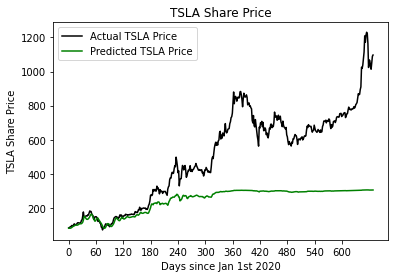

In [9]:
### Plot the test prediction

# Plotting the lines STH I CHANGED AND DID I AM PROUD
plt.plot(x_axis_actual_prices, actual_prices, color = "black", label = f"Actual {company} Price")
plt.plot(x_axis_predicted_prices, predicted_prices, color = "green", label = f"Predicted {company} Price")
# Axis'
plt.title(f"{company} Share Price")
plt.xlabel('Days since Jan 1st 2020')
plt.ylabel(f'{company} Share Price')
# Labels on bottom x-axis stated
plt.xticks([0, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600])
plt.legend()
plt.show()

In [10]:
# Predict next day
real_data = []
# Looked at the method of predicting from before anad basically copied this append to list bit, switching how take from list
for x in range(prediction_days, len(model_inputs)):
    real_data.append(model_inputs[len(model_inputs) - prediction_days:len(model_inputs + 1), 0])
    
# Making it an array
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

# Prediction
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
# Giving me the value, only 1 into the future though
print(f"Prediction: {prediction[0]}")

Prediction: [306.08267]
